In [26]:
!pip install pmdarima


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima





Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66016 entries, 0 to 66015
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customer_id     26585 non-null  object 
 1   disb_date       26585 non-null  object 
 2   tenure          26585 non-null  object 
 3   account_num     26585 non-null  object 
 4   loan_amount     26585 non-null  float64
 5   loan_fee        26585 non-null  float64
 6   date_time       66016 non-null  object 
 7   customer_id     66016 non-null  object 
 8   amount          66016 non-null  float64
 9   rep_month       66016 non-null  int64  
 10  repayment_type  66016 non-null  object 
dtypes: float64(3), int64(1), object(7)
memory usage: 5.5+ MB
None

Summary Statistics:
        loan_amount      loan_fee        amount      rep_month
count  26585.000000  26585.000000  66016.000000   66016.000000
mean    1001.021403    129.698904    462.056628  202404.374697
std     

<ipython-input-28-ad285d64c4ef>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Forward fill as a simple strategy


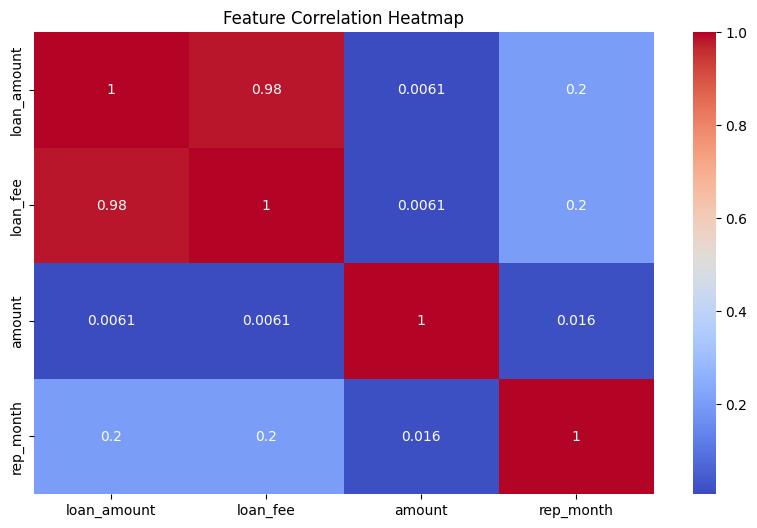

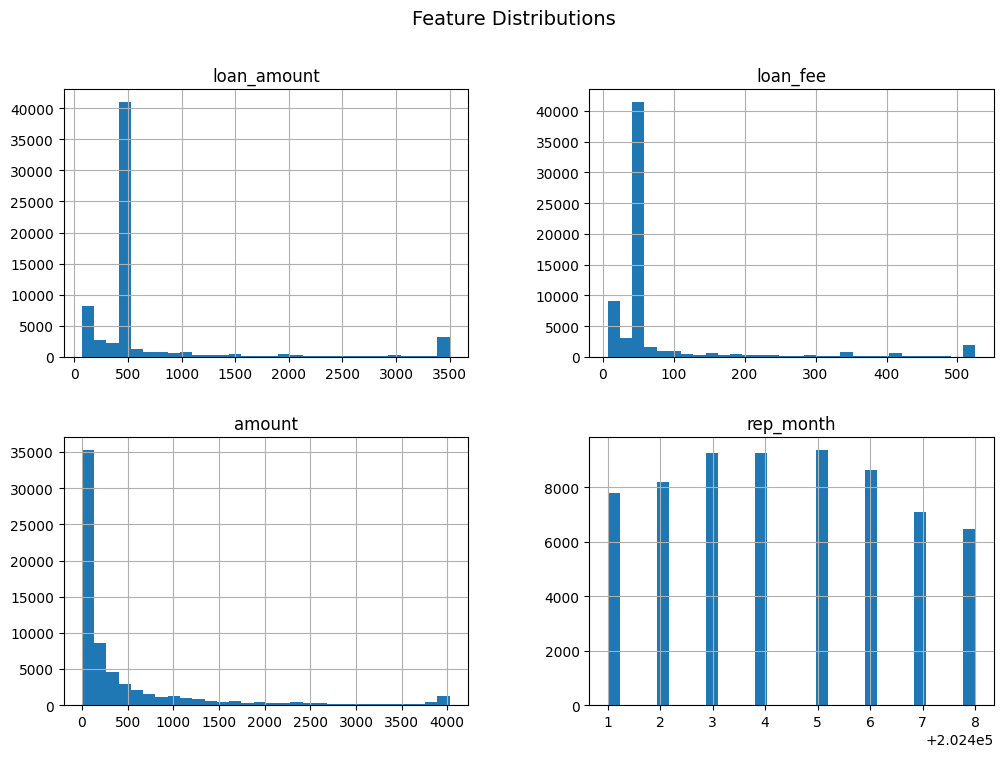

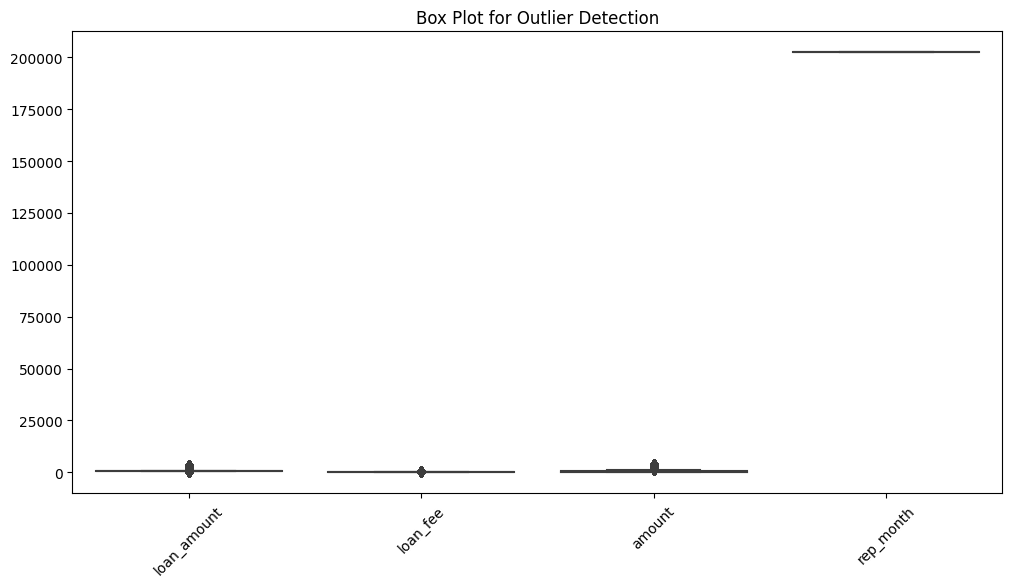

customer_id       0
disb_date         0
tenure            0
account_num       0
loan_amount       0
loan_fee          0
date_time         0
customer_id       0
amount            0
rep_month         0
repayment_type    0
dtype: int64

In [28]:
# Load datasets
disbursements = pd.read_csv("/kaggle/input/madedatasets/disbursements.csv")
repayments = pd.read_csv("/kaggle/input/madedatasets/repayments.csv")

# Convert date columns to datetime
if 'date' in disbursements.columns:
    disbursements['date'] = pd.to_datetime(disbursements['date'])
if 'date' in repayments.columns:
    repayments['date'] = pd.to_datetime(repayments['date'])

# Merge datasets
if 'date' in disbursements.columns and 'date' in repayments.columns:
    data = pd.merge(disbursements, repayments, on='date', how='outer', suffixes=('_disb', '_repay'))
else:
    data = pd.concat([disbursements, repayments], axis=1)

# Display basic information
print("Dataset Information:")
print(data.info())
print("\nSummary Statistics:")
print(data.describe())

# Handling missing values
data.fillna(method='ffill', inplace=True)  # Forward fill as a simple strategy

# Select only numeric columns for EDA
numeric_data = data.select_dtypes(include=['number'])

# Heatmap to check correlations
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Scatter plots
if 'amount_disb' in data.columns and 'amount_repay' in data.columns:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=data['amount_disb'], y=data['amount_repay'])
    plt.xlabel("Disbursed Amount")
    plt.ylabel("Repaid Amount")
    plt.title("Scatter Plot of Disbursements vs Repayments")
    plt.show()

# Histogram for distributions
numeric_data.hist(figsize=(12, 8), bins=30)
plt.suptitle("Feature Distributions", fontsize=14)
plt.show()

# Box plot to check for outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=numeric_data)
plt.xticks(rotation=45)
plt.title("Box Plot for Outlier Detection")
plt.show()

# Print null values after handling
data.isnull().sum()

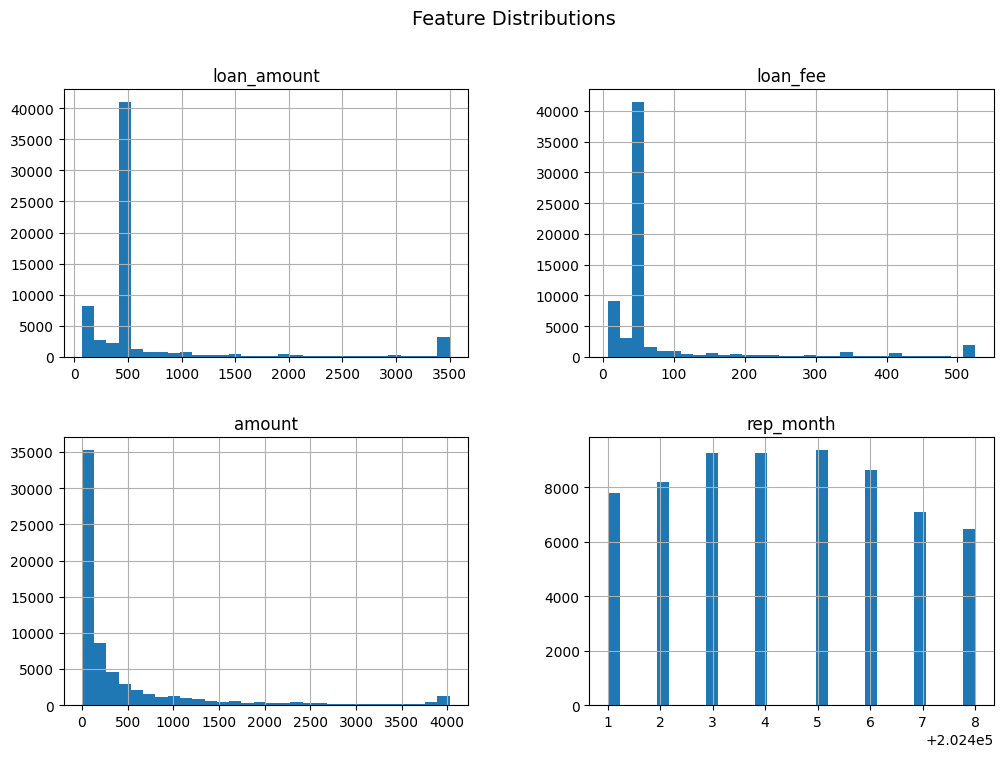

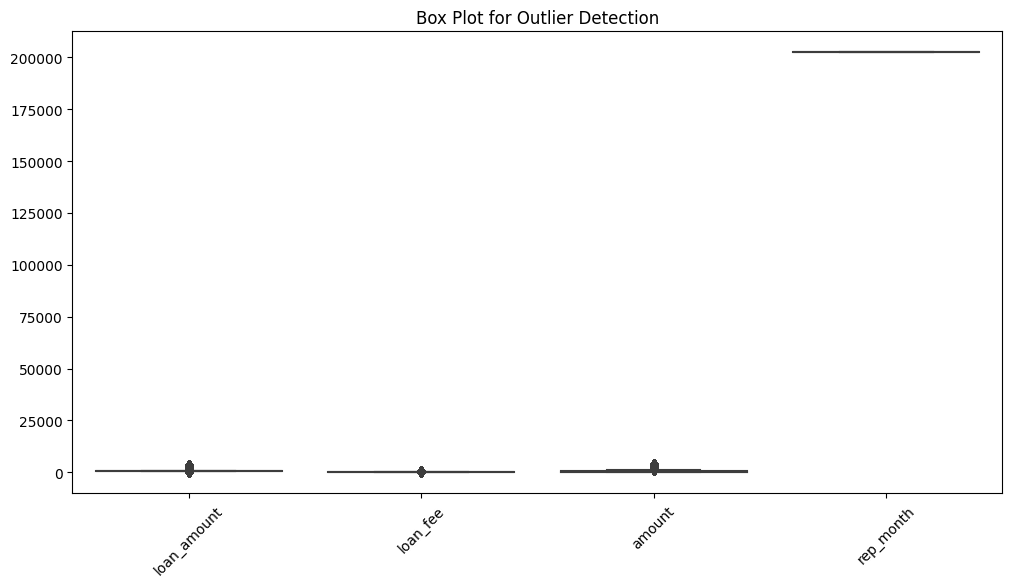

customer_id       0
disb_date         0
tenure            0
account_num       0
loan_amount       0
loan_fee          0
date_time         0
customer_id       0
amount            0
rep_month         0
repayment_type    0
dtype: int64

In [29]:
# Scatter plots
if 'amount_disb' in data.columns and 'amount_repay' in data.columns:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=data['amount_disb'], y=data['amount_repay'])
    plt.xlabel("Disbursed Amount")
    plt.ylabel("Repaid Amount")
    plt.title("Scatter Plot of Disbursements vs Repayments")
    plt.show()

# Histogram for distributions
numeric_data.hist(figsize=(12, 8), bins=30)
plt.suptitle("Feature Distributions", fontsize=14)
plt.show()

# Box plot to check for outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=numeric_data)
plt.xticks(rotation=45)
plt.title("Box Plot for Outlier Detection")
plt.show()

# Print null values after handling
data.isnull().sum()


In [30]:
# Time Series Analysis & Forecasting
if 'date' in data.columns and 'amount_disb' in data.columns and 'amount_repay' in data.columns:
    data.set_index('date', inplace=True)
    data.sort_index(inplace=True)
    
    # Ensure time series data is numeric
    data['amount_disb'] = pd.to_numeric(data['amount_disb'], errors='coerce')
    data['amount_repay'] = pd.to_numeric(data['amount_repay'], errors='coerce')
    
    # Drop NaN values for time series analysis
    data.dropna(inplace=True)
    
    # Time series decomposition
    decomposition = sm.tsa.seasonal_decompose(data['amount_disb'], model='additive', period=12)
    fig = decomposition.plot()
    fig.set_size_inches(10, 8)
    plt.show()
    
    # Stationarity test (ADF test)
    result = adfuller(data['amount_disb'].dropna())
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    
    # ACF and PACF plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sm.graphics.tsa.plot_acf(data['amount_disb'].dropna(), lags=30, ax=axes[0])
    sm.graphics.tsa.plot_pacf(data['amount_disb'].dropna(), lags=30, ax=axes[1])
    plt.show()
    
    # ARIMA Forecasting for Disbursements
    model_disb = auto_arima(data['amount_disb'], seasonal=True, m=12, trace=True, suppress_warnings=True)
    model_fit_disb = ARIMA(data['amount_disb'], order=model_disb.order).fit()
    forecast_disb = model_fit_disb.forecast(steps=12)
    
    # ARIMA Forecasting for Repayments
    model_repay = auto_arima(data['amount_repay'], seasonal=True, m=12, trace=True, suppress_warnings=True)
    model_fit_repay = ARIMA(data['amount_repay'], order=model_repay.order).fit()
    forecast_repay = model_fit_repay.forecast(steps=12)
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['amount_disb'], label='Actual Disbursements', color='blue')
    plt.plot(pd.date_range(start=data.index[-1], periods=12, freq='M'), forecast_disb, label='Forecasted Disbursements', linestyle='dashed', color='blue')
    plt.plot(data.index, data['amount_repay'], label='Actual Repayments', color='red')
    plt.plot(pd.date_range(start=data.index[-1], periods=12, freq='M'), forecast_repay, label='Forecasted Repayments', linestyle='dashed', color='red')
    plt.xlabel("Date")
    plt.ylabel("Amount")
    plt.title("Disbursement & Repayment Forecast (ARIMA)")
    plt.legend()
    plt.show()
